In [71]:
#necessary imports
import random as rand
import numpy as np
from tabulate import tabulate
from random import shuffle, random, sample, randint, randrange, uniform

In [230]:
class Item:
    def __init__(self, weight):
        self.weight = weight # Peso del item. Se impone una restriccion en el peso maximo de un bin

In [473]:
class Candidate:
    def __init__(self, bins, population, peso_maximo,ItemPool, chromosome=None):
        """
        Initialise a candidate solution, as defined by the listed parameters, and immediatelly evaluate its fitness.
        :param bins: The number of bins (defined by problem)
        :param items: The items to be bin packed (defined by problem)
        :param chromosome: A candidate solution depicting item distribution in bins
        """
        
        self.bins = bins 
        self.population = population
        self.peso_maximo = peso_maximo
        self.ItemPool = ItemPool
        
        # during generation of initial population, chromosomes are not specified and are instead randomly generated
        if chromosome is None:
            
            # generate an array of random ints representing bin allocation
            self.chromosome = np.random.randint(low=0, high=self.bins+1, size=len(self.ItemPool))
        else:
            self.chromosome = chromosome
            
        self.fitness = self.calculate_fitness()
        
    def calculate_fitness(self):
        """
        A fitness function is defined here as the difference in weight of the heaviest bin and the lightest bin.
        :returns: fitness as defined
        """
        
        bin_weights = {}
        for n in range(self.bins+1):
          bin_weights[n] = 0  
        # allocate item weights to bins using the chromosome (bin allocation)
        for idx, allocation in enumerate(self.chromosome):                          
            # for each gene/allocation, add weight to appropriate bag count
            bin_weights[allocation] += self.ItemPool[idx].weight
        
        sum=0
        for bin in bin_weights:
          if  bin ==0:
            sum += bin_weights[bin]
          elif bin_weights[bin]>self.peso_maximo:
            return 10000
          else:
            sum += self.peso_maximo-bin_weights[bin]
        return sum
    
    def m_gene_mutation(self):
        """
        Perform m-gene mutation on candidate solution and amend it's chromosome as appropriate
        :param m: Number of times to perform the mutation
        """
        # perform single gene mutation m times
        choose_gene = rand.randint(0, len(self.chromosome)-1)
        self.chromosome[choose_gene] = rand.randint(1,self.bins)

        
    def m_gene_mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = self.chromosome[:]
        ## ESCRIBIR AQUI SU CODIGO
        chromosome_len = len(new_chromosome)
        ix_to_mutate = np.random.choice(chromosome_len, chromosome_len // 2, replace=False) #retorna lista de indices que representan el 50% de genes
        for ix in ix_to_mutate:
          new_chromosome[ix] = rand.randint(1,self.bins) 
        self.chromosome = new_chromosome

        
def single_point_crossover(parent_a,parent_b):
    """
    Perform single point crossover on parents and return resultant children
    :param parent_a: A parent chromosome
    :param parent_b: A parent chromosome
    
    :returns child_a: child chromosome
    :returns child_b: child chromosome
    """
    
    # choose a random index for crossover point
    crossover_point = rand.randint(1, len(parent_a)-2)
    
    # split parents down this crossover point
    parent_a_start, parent_a_end = parent_a[:crossover_point], parent_a[crossover_point:]
    parent_b_start, parent_b_end = parent_b[:crossover_point], parent_b[crossover_point:]
    
    # combine parent pieces to form children
    child_a = np.hstack((parent_a_start, parent_b_end))
    child_b = np.hstack((parent_a_end, parent_b_start))
    
    return child_a, child_b

def uniform_crossover(parent_a, parent_b):
    chromosome1 = []
    chromosome2 = []
    "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
    for i in range(len(parent_a)):
        if uniform(0, 1) < 0.5:
            chromosome1.append(parent_a[i])
            chromosome2.append(parent_b[i])
        else:
            chromosome1.append(parent_b[i])
            chromosome2.append(parent_a[i])
    parent_a = np.array(chromosome1)
    parent_b = np.array(chromosome2)
    return parent_a, parent_b 



def binary_tournament(population):
    """
    Perform binary tornament without replacement on population
    :param population: List of candidate solution objects
    """
    # select 2 random candidates
    # here replace is set to false to avoid a tournament between the same object
    candidates = np.random.choice(population, 2, replace=False)
    
    # return the candidate of smallest fitness value
    return min(candidates, key=lambda candidate: candidate.fitness)

def weakest_replacement(population, candidate):
    """
    Find weakest current population memeber and compare them to the candidate. 
    Replace with candidate if candidate has a better fitness function.
    
    :param population:List of candidate solution objects
    :param candidate: A candidate solution object
    """
    
    # Find the worst solution
    worst_solution = min(population, key=lambda solution: solution.fitness)
    
    if candidate.fitness <= worst_solution.fitness:
        population.remove(worst_solution)
        population.append(candidate)
        
    return population


def solve_bin(bins,m,cross_type, mut_type, population,peso_maximo,ItemPool,generation, crossover=True,):
    """
    Run the bin packing EA, with the specified parameters.
    :param bins: The number of bins as defined in problem
    :param items: The list of items as defined by problem
    :param m: The mutation coefficient
    :param population: The size of the population
    :param crossover: Whether to include crossover
    :param peso_maximo: Whether to include crossomuver
    :param peso_maximo: Whether to include crossover
    """
    # initiate iterations
    itr = 0
    #generate random population
    pop = [Candidate(bins=bins,peso_maximo=peso_maximo,ItemPool=ItemPool,population=population) for _ in range(population)]
    # as candidates are evaluated upon iteration increment iterations for each of the above candiates
    itr += population
    #ix = 0
    lst_hist_fitness = []
    for g in range(generation):
       for i in range(int(population)): 
          #while itr < 10000:
          #ix += 1
          # binary tournament to find parents
          parent_a, parent_b = binary_tournament(pop), binary_tournament(pop)
          if crossover:   
              if cross_type == "onepoint":
                  child_a, child_b = single_point_crossover(parent_a.chromosome,parent_b.chromosome)
              elif cross_type == "uniform":
                  child_a, child_b = uniform_crossover(parent_a.chromosome,parent_b.chromosome)
              else:
                  raise NotImplementedError

              # children chromosomes created via single point crossover
              
          else:
              #no crossover so children just inherit parents' chromosomes
              child_a, child_b = parent_a.chromosome[:], parent_b.chromosome[:]
              
          #create child objects using the above chromosomes
          child_a = Candidate(bins=bins, peso_maximo=peso_maximo,population=population,ItemPool=ItemPool, chromosome = child_a)
          child_b = Candidate(bins=bins, peso_maximo=peso_maximo,population=population,ItemPool=ItemPool, chromosome = child_b)
          
          #check for mutation coefficient (no need to call function if mutation set to 0)
          if m != 0:

              if uniform(0, 1) < m: 
                if mut_type == "flip":
                  child_a.m_gene_mutation()
                  child_b.m_gene_mutation()
                elif mut_type == "multiflip":
                  child_a.m_gene_mutation_multiflip()
                  child_b.m_gene_mutation_multiflip()
                else:
                  raise NotImplementedError
      
              # evaluate children
              child_a.fitness= child_a.calculate_fitness()
              child_b.fitness = child_b.calculate_fitness()
          
          #incrmeent evaluation counter for each child being evaluated
          # update population using weakest replacement
          pop = weakest_replacement(pop, child_a)
          pop = weakest_replacement(pop, child_b)
       lst_hist_fitness.append(min(pop, key=lambda solution: solution.fitness).fitness)
    # return the candidate with minimal fitness function from the entire population
    # this is the top candidate
    best_candidate = min(pop, key=lambda solution: solution.fitness)
    best_fitness = best_candidate.fitness
    best_chromosome = best_candidate.chromosome
    return  best_fitness, best_chromosome,lst_hist_fitness  #min(pop, key=lambda solution: solution.fitness).chromosome ,min(pop, key=lambda solution: solution.fitness).fitness
    

In [453]:
# test runner
def run_trial(trial_name,bins,mutation,crossover, population,n_trials,peso_maximo, ItemPool,generation, cross_type, mut_type ):
    """
    Run Tests with warying parameters.
    """
    fitness_lst = []
    chromosome_lst =[]
    hist_fitness_lst =[]

    for n in range(n_trials):
        print("Running Trial", trial_name, ": ", n+1 , "/", n_trials)
        # set random seed
        rand.seed(n)
        np.random.seed(n)        
        #result, fitnes = solve_bin(bins, mutation,population, peso_maximo,ItemPool, crossover=crossover)
        fitness, chromosome, hist_fitness = solve_bin(bins, mutation,cross_type, mut_type, population, peso_maximo,ItemPool,generation, crossover=crossover)
        fitness_lst.append(fitness)
        chromosome_lst.append(chromosome)
        hist_fitness_lst.append(hist_fitness)
    
    #print()
    return fitness_lst, chromosome_lst, hist_fitness_lst
    
    

#EJECUCION DE ALGORITMO

In [552]:
NUM_BINS = 5
NUM_POPULATION = 30       # numero de items
NUM_ITEMS = 10     # numero de items
MAX_ITEM_WEIGHT = 150  # maximo peso posible de cada  item
NUM_TRIALS = 10
NUM_GENERATION = 100
#pool de items generado aleatoriamente


In [553]:
ItemPool = [ Item(randint(1,MAX_ITEM_WEIGHT)) for x in range (0,NUM_ITEMS)]


In [555]:
bpp1_results = [[] for x in range(14)]
bpp1_results[0] = run_trial("Crossover OnePoint and M0",NUM_BINS, 0, True,NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[1] = run_trial("Crossover Uniform and M0",NUM_BINS, 0, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform', mut_type='flip')
bpp1_results[2] = run_trial("Crossover OnePoint and M1 flip", NUM_BINS, 0.1, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bpp1_results[3] = run_trial("Crossover OnePoint and M3 flip", NUM_BINS, 0.3, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='flip')
bpp1_results[4] = run_trial("Crossover OnePoint and M5 flip", NUM_BINS, 0.5, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[5] = run_trial("Crossover OnePoint and M8 flip", NUM_BINS, 0.8, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip')
bpp1_results[6] = run_trial("Crossover Uniform and M1 flip", NUM_BINS, 0.1, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[7] = run_trial("Crossover Uniform and M3 flip", NUM_BINS, 0.3, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[8] = run_trial("Crossover Uniform and M5 flip", NUM_BINS, 0.5, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[9] = run_trial("Crossover Uniform and M8 flip", NUM_BINS, 0.8, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='flip',)
bpp1_results[10] = run_trial("No Crossover M1 flip", NUM_BINS, 0.1, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[11] = run_trial("No Crossover M3 flip", NUM_BINS, 0.3, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[12] = run_trial("No Crossover M5 flip", NUM_BINS, 0.5, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)
bpp1_results[13] = run_trial("No Crossover M8 flip", NUM_BINS, 0.8, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='flip',)


Running Trial Crossover OnePoint and M0 :  1 / 10
Running Trial Crossover OnePoint and M0 :  2 / 10
Running Trial Crossover OnePoint and M0 :  3 / 10
Running Trial Crossover OnePoint and M0 :  4 / 10
Running Trial Crossover OnePoint and M0 :  5 / 10
Running Trial Crossover OnePoint and M0 :  6 / 10
Running Trial Crossover OnePoint and M0 :  7 / 10
Running Trial Crossover OnePoint and M0 :  8 / 10
Running Trial Crossover OnePoint and M0 :  9 / 10
Running Trial Crossover OnePoint and M0 :  10 / 10
Running Trial Crossover Uniform and M0 :  1 / 10
Running Trial Crossover Uniform and M0 :  2 / 10
Running Trial Crossover Uniform and M0 :  3 / 10
Running Trial Crossover Uniform and M0 :  4 / 10
Running Trial Crossover Uniform and M0 :  5 / 10
Running Trial Crossover Uniform and M0 :  6 / 10
Running Trial Crossover Uniform and M0 :  7 / 10
Running Trial Crossover Uniform and M0 :  8 / 10
Running Trial Crossover Uniform and M0 :  9 / 10
Running Trial Crossover Uniform and M0 :  10 / 10
Running 

In [556]:
bpp2_results = [[] for x in range(14)]
bpp2_results[0] = run_trial("Crossover OnePoint and M1 multiflip", NUM_BINS, 0.1, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='multiflip')
bpp2_results[1] = run_trial("Crossover OnePoint and M3 multiflip", NUM_BINS, 0.3, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint', mut_type='multiflip')
bpp2_results[2] = run_trial("Crossover OnePoint and M5 multiflip", NUM_BINS, 0.5, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip')
bpp2_results[3] = run_trial("Crossover OnePoint and M8 multiflip", NUM_BINS, 0.8, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip')
bpp2_results[4] = run_trial("Crossover Uniform and M1 multiflip", NUM_BINS, 0.1, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[5] = run_trial("Crossover Uniform and M3 multiflip", NUM_BINS, 0.3, True, NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[6] = run_trial("Crossover Uniform and M5 multiflip", NUM_BINS, 0.5, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[7] = run_trial("Crossover Uniform and M8 multiflip", NUM_BINS, 0.8, True,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='uniform',mut_type='multiflip',)
bpp2_results[8] = run_trial("No Crossover M1 multiflip", NUM_BINS, 0.1, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[9] = run_trial("No Crossover M3 multiflip", NUM_BINS, 0.3, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[10] = run_trial("No Crossover M5 multiflip", NUM_BINS, 0.5, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)
bpp2_results[11] = run_trial("No Crossover M8 multiflip", NUM_BINS, 0.8, False,  NUM_POPULATION, NUM_TRIALS, MAX_ITEM_WEIGHT,ItemPool,NUM_GENERATION,cross_type='onepoint',mut_type='multiflip',)


Running Trial Crossover OnePoint and M1 multiflip :  1 / 10
Running Trial Crossover OnePoint and M1 multiflip :  2 / 10
Running Trial Crossover OnePoint and M1 multiflip :  3 / 10
Running Trial Crossover OnePoint and M1 multiflip :  4 / 10
Running Trial Crossover OnePoint and M1 multiflip :  5 / 10
Running Trial Crossover OnePoint and M1 multiflip :  6 / 10
Running Trial Crossover OnePoint and M1 multiflip :  7 / 10
Running Trial Crossover OnePoint and M1 multiflip :  8 / 10
Running Trial Crossover OnePoint and M1 multiflip :  9 / 10
Running Trial Crossover OnePoint and M1 multiflip :  10 / 10
Running Trial Crossover OnePoint and M3 multiflip :  1 / 10
Running Trial Crossover OnePoint and M3 multiflip :  2 / 10
Running Trial Crossover OnePoint and M3 multiflip :  3 / 10
Running Trial Crossover OnePoint and M3 multiflip :  4 / 10
Running Trial Crossover OnePoint and M3 multiflip :  5 / 10
Running Trial Crossover OnePoint and M3 multiflip :  6 / 10
Running Trial Crossover OnePoint and M3

In [210]:
len(bpp1_results)

8

In [557]:
#all results
header = ["Problem 1","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table1 = ([["Crossover OnePoint and M0", *bpp1_results[0][0], sum(bpp1_results[0][0])/NUM_TRIALS],
          ["Crossover Uniform and M0", *bpp1_results[1][0], sum(bpp1_results[1][0])/NUM_TRIALS],
          ["Crossover OnePoint and M1 flip", *bpp1_results[2][0], sum(bpp1_results[2][0])/NUM_TRIALS],
          ["Crossover OnePoint and M3 flip", *bpp1_results[3][0], sum(bpp1_results[3][0])/NUM_TRIALS],
          ["Crossover OnePoint and M5 flip", *bpp1_results[4][0], sum(bpp1_results[4][0])/NUM_TRIALS],
          ["Crossover OnePoint and M8 flip", *bpp1_results[5][0], sum(bpp1_results[5][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 flip", *bpp1_results[6][0], sum(bpp1_results[6][0])/NUM_TRIALS],
          ["Crossover Uniform and M3 flip", *bpp1_results[7][0], sum(bpp1_results[7][0])/NUM_TRIALS],
          ["Crossover Uniform and M5 flip", *bpp1_results[8][0], sum(bpp1_results[8][0])/NUM_TRIALS],
          ["Crossover Uniform and M8 flip", *bpp1_results[9][0], sum(bpp1_results[9][0])/NUM_TRIALS],
          ["No Crossover M1 flip", *bpp1_results[10][0], sum(bpp1_results[10][0])/NUM_TRIALS],
          ["No Crossover M3 flip", *bpp1_results[11][0], sum(bpp1_results[11][0])/NUM_TRIALS],
          ["No Crossover M5 flip", *bpp1_results[12][0], sum(bpp1_results[12][0])/NUM_TRIALS],
          ["No Crossover M8 flip", *bpp1_results[13][0], sum(bpp1_results[13][0])/NUM_TRIALS],
          ]
         )
print(tabulate(table1, headers=header))
print("--------------------------------------------------------------------------------------------------------------------")
           

Problem 1                         Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M0             255        269        337        317        233        283        241        337        233         249      275.4
Crossover Uniform and M0              213        199        269      10000        233        269        199        199        233         199     1201.3
Crossover OnePoint and M1 flip        301        213        337        233      10000        269        325        339        213         241     1247.1
Crossover OnePoint and M3 flip        247        269        233        233        233        199        199        269        233         233      234.8
Crossover OnePoint and M5 flip        269        213        199        233      10

In [558]:
#all results
header = ["Problem 1","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table2 = ([
          ["Crossover OnePoint and M1 multiflip", *bpp2_results[0][0], sum(bpp2_results[0][0])/NUM_TRIALS],
          ["Crossover OnePoint and M3 multiflip", *bpp2_results[1][0], sum(bpp2_results[1][0])/NUM_TRIALS],
          ["Crossover OnePoint and M5 multiflip", *bpp2_results[2][0], sum(bpp2_results[2][0])/NUM_TRIALS],
          ["Crossover OnePoint and M8 multiflip", *bpp2_results[3][0], sum(bpp2_results[3][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 multiflip", *bpp2_results[4][0], sum(bpp2_results[4][0])/NUM_TRIALS],
          ["Crossover Uniform and M3 multiflip", *bpp2_results[5][0], sum(bpp2_results[5][0])/NUM_TRIALS],
          ["Crossover Uniform and M5 multiflip", *bpp2_results[6][0], sum(bpp2_results[6][0])/NUM_TRIALS],
          ["Crossover Uniform and M8 multiflip", *bpp2_results[7][0], sum(bpp2_results[7][0])/NUM_TRIALS],
          ["No Crossover M1 multiflip", *bpp2_results[8][0], sum(bpp2_results[8][0])/NUM_TRIALS],
          ["No Crossover M3 multiflip", *bpp2_results[9][0], sum(bpp2_results[9][0])/NUM_TRIALS],
          ["No Crossover M5 multiflip", *bpp2_results[10][0], sum(bpp2_results[10][0])/NUM_TRIALS],
          ["No Crossover M8 multiflip", *bpp2_results[11][0], sum(bpp2_results[11][0])/NUM_TRIALS],
          ]
         )
print(tabulate(table2, headers=header))
print("--------")

Problem 1                              Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
-----------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M1 multiflip        199        249        241      10000        249        199        241        241        233         241     1209.3
Crossover OnePoint and M3 multiflip        367        213      10000      10000      10000        249        227        233        249         233     3177.1
Crossover OnePoint and M5 multiflip      10000        213      10000        241      10000        233        233        233        241         233     3162.7
Crossover OnePoint and M8 multiflip      10000        325      10000      10000      10000        199        241        233        199         233     4143
Crossover Uniform and M1 multiflip         323        

RESULTADOS

TABLA TOP 3 MEJOR AVG

In [588]:
#all results
header = ["Mejores operadores","Trial 1","Trial 2","Trial 3","Trial 4","Trial 5","Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10" ,"Average" ]
table2 = ([
          ["Crossover OnePoint and M3 flip ", *bpp1_results[3][0], sum(bpp1_results[3][0])/NUM_TRIALS],
          ["Crossover Uniform and M1 multiflip", *bpp2_results[4][0], sum(bpp2_results[4][0])/NUM_TRIALS],
          ["Crossover OnePoint and M0", *bpp1_results[0][0], sum(bpp1_results[0][0])/NUM_TRIALS],
         
          ]
         )
print(tabulate(table2, headers=header))
print("--------")

mejores operadores                    Trial 1    Trial 2    Trial 3    Trial 4    Trial 5    Trial 6    Trial 7    Trial 8    Trial 9    Trial 10    Average
----------------------------------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------
Crossover OnePoint and M3 flip            247        269        233        233        233        199        199        269        233         233      234.8
Crossover Uniform and M1 multiflip        323        269        233        233        199        199        233        233        233         269      242.4
Crossover OnePoint and M0                 255        269        337        317        233        283        241        337        233         249      275.4
--------


#Mejores combinaciones encontradas

* Crossover OnePoint and M3 flip  = avg => 234 (199 - Trial 6)




* Crossover Uniform and M1 multiflip = avg => 242(199 Trial 5)

In [559]:
import matplotlib.pyplot as plt

#**GRAFICOS MEJOR RESULTADO**

**Crossover OnePoint and M3 flip  = avg => 234 (199 - Trial 6)**

**Mejor cromosoma**

In [562]:
best_result = bpp1_results[3]

In [573]:
best_result[1][5]

array([2, 3, 5, 1, 2, 4, 1, 0, 5, 3])

**Histograma de cromosoma con mejor fitness por generación**

Text(0.5, 1.0, 'Histograma de cromosoma con mejor fitness por generación')

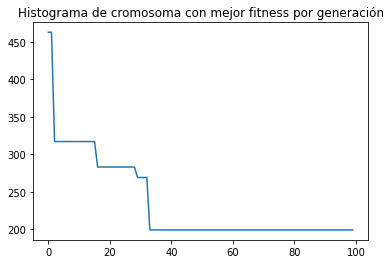

In [563]:
plt.plot(best_result[2][5])
plt.title("Histograma de cromosoma con mejor fitness por generación")

**Evolución de mejor fitness por trial de operador con mejores resultados**

Text(0.5, 1.0, 'Evolución de mejor fitness por trial de operador con mejores resultados')

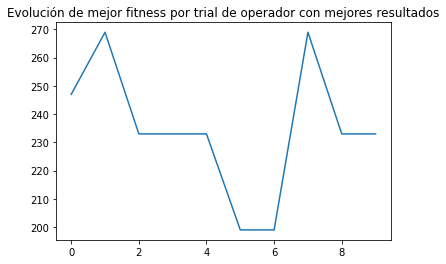

In [564]:
plt.plot(best_result[0])
plt.title("Evolución de mejor fitness por trial de operador con mejores resultados")

**Generación en la que se encontró el mejor fitness por trial**

Text(0.5, 1.0, 'Generación en la que se encontró el mejor fitness por trial')

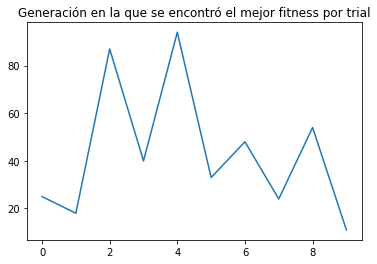

In [566]:
lst_grf = [ x.index(min(x)) for x in best_result[2]]
plt.plot(lst_grf)
plt.title("Generación en la que se encontró el mejor fitness por trial")

In [571]:
import pandas as pd
df_lst = []
for ix,x in enumerate(best_result[1][5]):
  df_lst.append({
      'item': ix + 1,
      'weight' : ItemPool[ix].weight,
      'bin' : x
  })
solucion = pd.DataFrame(df_lst)

**Dataset de distribución por bin y item**

In [572]:
solucion

,item,weight,bin
0,1,111,2
1,2,45,3
2,3,62,5
3,4,7,1
4,5,34,2
5,6,115,4
6,7,107,1
7,8,90,0
8,9,63,5
9,10,97,3


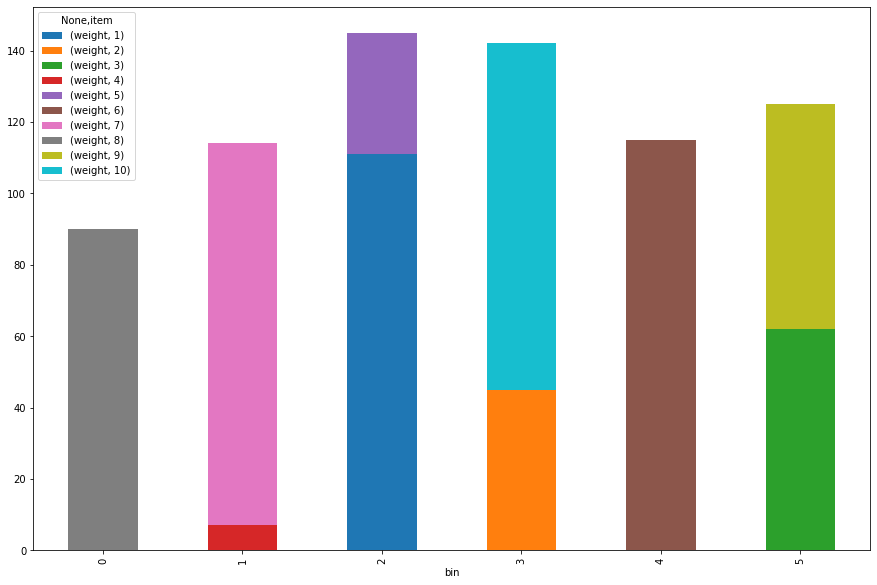

In [575]:
ax = solucion.groupby(['bin', 'item']).sum().unstack().plot(kind='bar', figsize=(15,10),stacked=True, legend=True)


#**GRAFICOS SEGUNDO MEJOR RESULTADO**

**Crossover Uniform and M1 multiflip = avg => 242(199 Trial 5)**

In [576]:
best_result = bpp2_results[4]

**Mejor cromosoma**

In [580]:
best_result[1][4]

array([5, 4, 3, 2, 5, 1, 2, 0, 3, 4])

**Histograma de evolución de fitness**

Text(0.5, 1.0, 'Histograma de cromosoma con mejor fitness por generación')

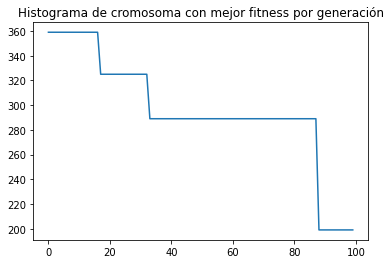

In [577]:
plt.plot(best_result[2][4])
plt.title("Histograma de cromosoma con mejor fitness por generación")

**Evolución de mejor fitness por trial**

Text(0.5, 1.0, 'Evolución de mejor fitness por trial de operador con mejores resultados')

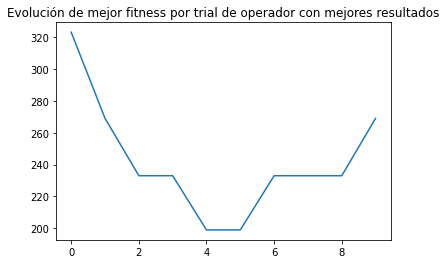

In [578]:
plt.plot(best_result[0])
plt.title("Evolución de mejor fitness por trial de operador con mejores resultados")

**Generación en la que se encontró el mejor fitness por trial**

Text(0.5, 1.0, 'Generación en la que se encontró el mejor fitness por trial')

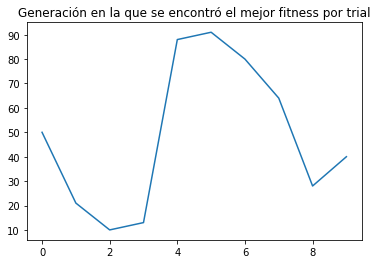

In [579]:
lst_grf = [ x.index(min(x)) for x in best_result[2]]
plt.plot(lst_grf)
plt.title("Generación en la que se encontró el mejor fitness por trial")

In [582]:
import pandas as pd
df_lst = []
for ix,x in enumerate(best_result[1][4]):
  df_lst.append({
      'item': ix + 1,
      'weight' : ItemPool[ix].weight,
      'bin' : x
  })
solucion = pd.DataFrame(df_lst)

**Dataset de distribución por bin y item**

In [583]:
solucion

,item,weight,bin
0,1,111,5
1,2,45,4
2,3,62,3
3,4,7,2
4,5,34,5
5,6,115,1
6,7,107,2
7,8,90,0
8,9,63,3
9,10,97,4


**Representación de bins**

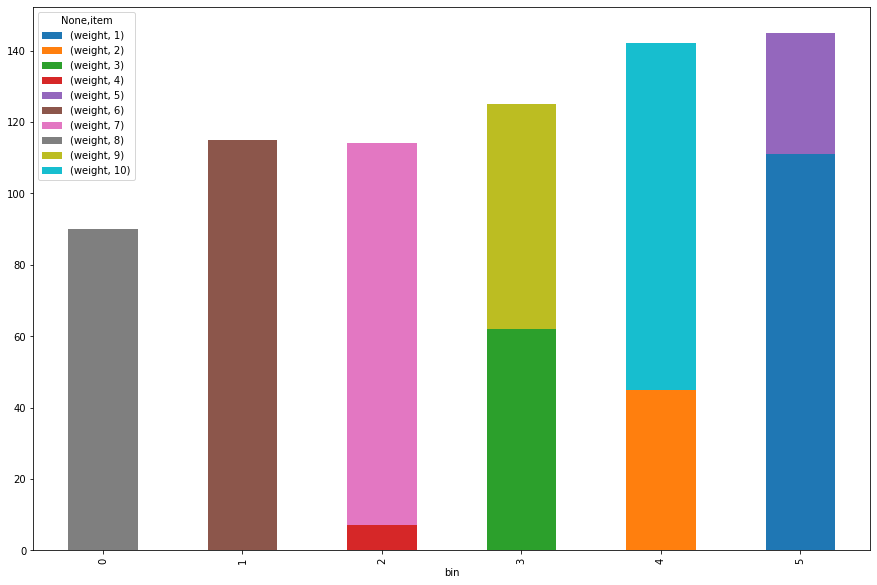

In [584]:
ax = solucion.groupby(['bin', 'item']).sum().unstack().plot(kind='bar', figsize=(15,10),stacked=True, legend=True)


In [590]:
[x.weight for x in ItemPool]

[111, 45, 62, 7, 34, 115, 107, 90, 63, 97]